# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [55]:
# import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import sqlite3
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from itertools import chain
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
register_matplotlib_converters()

In [2]:
# load data from database
conn = sqlite3.connect('DisasterResponse_r13.db')
df = pd.read_sql('SELECT * FROM MessCatRaw', con = conn)

In [3]:
# check the basics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43947 entries, 0 to 43946
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      43947 non-null  int64 
 1   message                 43947 non-null  object
 2   related                 43947 non-null  int64 
 3   request                 43947 non-null  int64 
 4   offer                   43947 non-null  int64 
 5   aid_related             43947 non-null  int64 
 6   medical_help            43947 non-null  int64 
 7   medical_products        43947 non-null  int64 
 8   search_and_rescue       43947 non-null  int64 
 9   security                43947 non-null  int64 
 10  military                43947 non-null  int64 
 11  child_alone             43947 non-null  int64 
 12  water                   43947 non-null  int64 
 13  food                    43947 non-null  int64 
 14  shelter                 43947 non-null  int64 
 15  cl

In [4]:
# target names
t_cols = df.columns[2:-2].tolist()
print('number of targets = ', len(t_cols))
print(t_cols)

number of targets =  36
['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [5]:
# split off validation set
dfv = df[df['val']==1].copy()
# independant train and test data 
dft = df[df['val']==0].copy()

# assign features and targets for validation
Xval = dfv['message'].copy()
Yval = dfv[t_cols].copy()

# assign features and targets for train and test
X = dft['message'].copy()
Y = dft[t_cols].copy()

In [6]:
# visualize breakdown of classes
counts = []
counts.append(('not_related',(len(df)-df['related'].sum())))
for t in t_cols:
    counts.append((t, df[t].sum()))
df_stats = pd.DataFrame(counts, columns = ['category', 'counts'])
df_stats

,category,counts
0,not_related,6112
1,related,37835
2,request,10849
3,offer,1219
4,aid_related,27455
5,medical_help,3891
6,medical_products,2490
7,search_and_rescue,2283
8,security,1880
9,military,2618


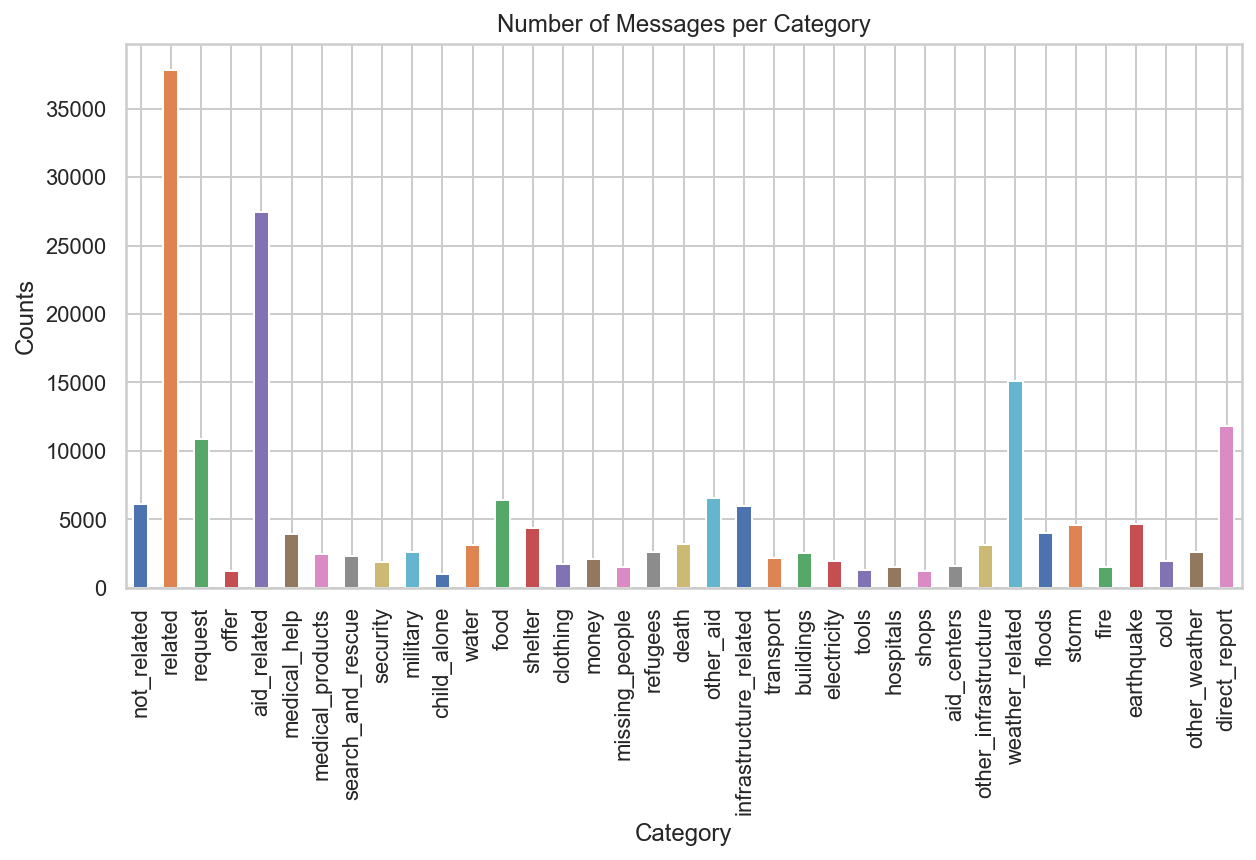

In [7]:
df_stats.plot(x='category',y='counts',kind='bar',
             legend=False, grid=True, figsize=(10,5),
             color=sns.color_palette())
plt.title('Number of Messages per Category')
plt.ylabel('Counts')
plt.xlabel('Category')
plt.show();

In [8]:
df_stats.describe()

,counts
count,37.000000
mean,5325.000000
std,7414.945467
min,999.000000
25%,1880.000000
50%,2621.000000
75%,4623.000000
max,37835.000000


### 2. Write a tokenization function to process your text data

In [9]:
def tokenize(text):
    '''
    input text string
    clean and lower case characters of string
    tokenize text
    lematize and remove stop words
    add bigrams
    return cleaned tokens and bigrams
    '''
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    # normalize
    s = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    # tokenize
    tokens = word_tokenize(s)
    # stemming
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # add bi-grams
    bigrams = [a + ' ' + b for a,b in list(nltk.bigrams(tokens))]
    return tokens + bigrams

### 3. Manage token frequencies
> Stop words are commonly pulled-out to improve performance.  
> Low frequency occurance tokens are also pulled out of the mix.  
> To do this token frequency filtering, a token frequency dictionary is built.  
> Note this is regarded as a corpus feature, not a train set feature.

In [10]:
def BuildFreqDict(messages):
    '''
    Import series of messages
    Tokenize messages
    Build Token Count dictionary
    Return Token Count dictionary
    '''
    texts = messages.apply(tokenize).tolist()
    dwf = Counter(chain.from_iterable(texts))
    return dwf   

In [11]:
# build frequency dictionary
dwf = BuildFreqDict(df['message'])

In [12]:
print(dwf.most_common(100))

[('number', 40441), ('help', 10075), ('people', 7613), ('food', 7141), ('water', 7133), ('number number', 6918), ('said', 6408), ('need', 5206), ('please', 4836), ('earthquake', 4532), ('also', 4325), ('area', 4062), ('u', 3163), ('sandy', 2889), ('affected', 2813), ('including', 2734), ('like', 2722), ('flood', 2684), ('country', 2611), ('year', 2509), ('government', 2507), ('rain', 2489), ('well', 2476), ('hit', 2468), ('path', 2344), ('would', 2323), ('house', 2317), ('relief', 2274), ('haiti', 2271), ('aid', 2247), ('know', 2246), ('tent', 2085), ('family', 2076), ('child', 2035), ('supply', 2013), ('find', 1924), ('get', 1873), ('still', 1859), ('go', 1855), ('day', 1844), ('destroyed', 1827), ('one', 1786), ('health', 1725), ('storm', 1724), ('region', 1704), ('village', 1700), ('disaster', 1672), ('school', 1664), ('killed', 1650), ('shelter', 1639), ('home', 1635), ('hurricane', 1630), ('help path', 1592), ('good', 1557), ('emergency', 1541), ('district', 1537), ('many', 1524),

In [13]:
# filter tokens by frequency
dtf = {x: count for x, count in dwf.items() if count >= 5}

#### Note each low frequency count cut-off controls thousands of word features.
#### Also note, filtering the high frequency token 'number' degrades classification performance.

In [14]:
# number of unique tokens
len(dtf)

33644

In [15]:
# save token frequency filter
with open('dict_tok_freq_r12.pkl', 'wb') as f:
    pickle.dump(dtf, f)

In [16]:
def PreProcess(text):
    '''
    input text string
    tokenize
    check if token in filtered frequencies
    return list of filtered tokens
    '''
    tokens = tokenize(text)
    return [t for t in tokens if t in dtf]

In [17]:
# evaluate filtering on training test set
dft['prep'] = dft['message'].apply(PreProcess)
dft['prep'].sample(10)

42917    [good, made, monsoonal, according, brought, se...
32100    [number, following, card, niece, causing, disa...
34739    [continuing, expected, noise, authority, emplo...
14924    [johannesburg, number, february, iron, botswan...
31929    [food, clogged, due, resource, heating, local,...
30231    [people, refused, also, friday, including, fai...
26371    [saw, girl, pink, hair, coughing, need, help, ...
40817    [water, united, louis, point, put, january, de...
7330     [got, problem, please, pick, card, problem ple...
9888     [haiti, hit, largest, earthquake, number, year...
Name: prep, dtype: object

Text(0, 0.5, 'Count')

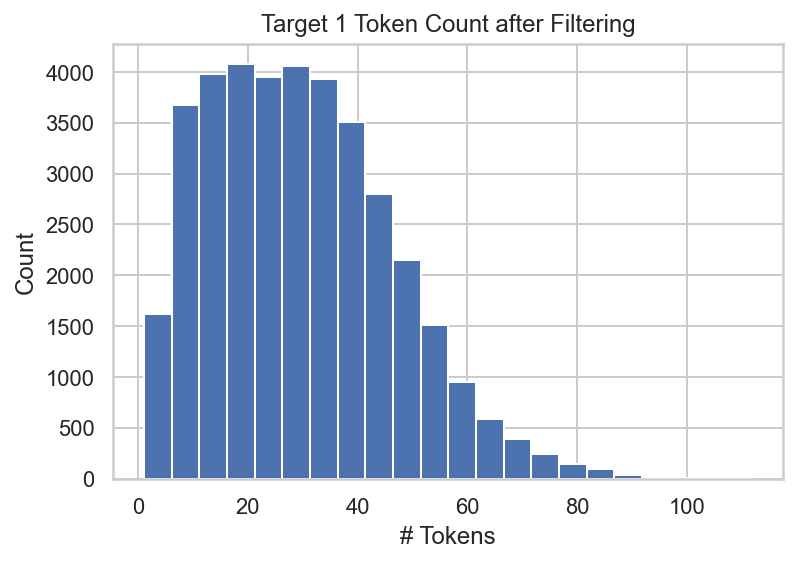

In [18]:
# Visualize number of tokens remaining
dft[dft['related']==1]['prep'].str.len().hist(bins=22)
plt.title('Target 1 Token Count after Filtering')
plt.xlabel('# Tokens')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

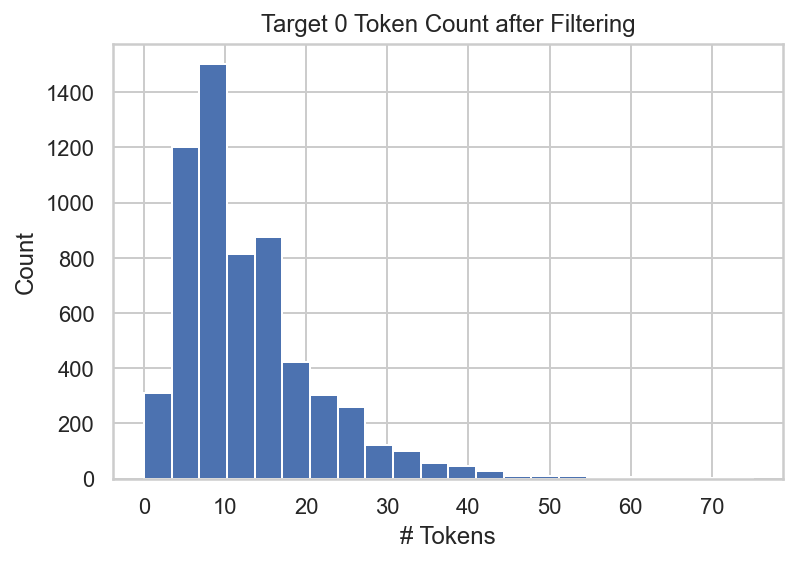

In [19]:
# Visualize number of tokens remaining
dft[dft['related']==0]['prep'].str.len().hist(bins=22)
plt.title('Target 0 Token Count after Filtering')
plt.xlabel('# Tokens')
plt.ylabel('Count')

### 4. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [20]:
# Attempt a small forest as a quick general first pass
under_samp = RandomUnderSampler()
forest = RandomForestClassifier(random_state=42, n_estimators=30)
clf = make_pipeline(under_samp, forest)
pipeline = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PreProcess, 
                                                 use_idf=True, 
                                                 sublinear_tf=True,
                                                 min_df=10,
                                                 ngram_range = (1,1))),
                     ('clf', MultiOutputClassifier(clf, n_jobs=1))])

### 5. Train pipeline
- Split data into train and test sets
- Train pipeline

In [21]:
# test train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

print(len(Y_train), len(Y_test))

21910 21911


In [22]:
# train classifier
pipeline.fit(X_train, Y_train)
# predict on test data
Y_pred = pipeline.predict(X_test)

### 6. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [23]:
def PrintClassReports(Y_predictions, Y_target):
    '''
    input classification predictions and targets
    compute figures
    print summary and estimate
    '''
    # classification reports
    cols = Y_target.columns.tolist()
    Y_targ = Y_target.to_numpy()
    for i in range(36):
        print(cols[i])
        print(classification_report(Y_targ.T[i],Y_predictions.T[i],
                                    zero_division=0))
        print('------------------------------------------------------')

In [24]:
def PrintFigures(Y_predicted, Y_target):
    '''
    input classification predictions and targets
    compute summary figures
    print figures
    '''
    # compute
    c1 = Y_predicted
    t1 = Y_target.to_numpy()
    tps = ((t1==c1)&(c1==1)).sum()
    fps = ((c1!=t1)&(t1==1)).sum()
    tng = ((t1==c1)&(c1==0)).sum()
    fng = ((c1!=t1)&(t1==0)).sum()
    pos = (t1==1).sum()
    neg = (t1==0).sum()
    recall = tps/(tps+fng)
    precis = tps/(tps+fps)
    TPR = tps/pos
    TNR = tng/neg
    bal_acc = (TPR + TNR)/2
    # print summary
    print('Target = 1 summary')
    print('True Positive Count = ', tps)
    print('False Negative Count = ', fng)
    print('Recall = ', "%.3f" % recall)
    print('Precision = ', "%.3f" % precis)
    print("Balanced Accuracy = ", "%.3f" % bal_acc)

In [25]:
# print metrics
PrintClassReports(Y_pred, Y_test)

related
              precision    recall  f1-score   support

           0       0.43      0.83      0.56      3038
           1       0.97      0.82      0.89     18873

    accuracy                           0.82     21911
   macro avg       0.70      0.83      0.73     21911
weighted avg       0.89      0.82      0.84     21911

------------------------------------------------------
request
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     16473
           1       0.54      0.73      0.62      5438

    accuracy                           0.78     21911
   macro avg       0.72      0.76      0.73     21911
weighted avg       0.81      0.78      0.79     21911

------------------------------------------------------
offer
              precision    recall  f1-score   support

           0       1.00      0.90      0.94     21256
           1       0.21      0.89      0.34       655

    accuracy                           0.90     21

              precision    recall  f1-score   support

           0       0.91      0.77      0.84     14422
           1       0.66      0.85      0.75      7489

    accuracy                           0.80     21911
   macro avg       0.79      0.81      0.79     21911
weighted avg       0.83      0.80      0.81     21911

------------------------------------------------------
floods
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     19948
           1       0.30      0.79      0.44      1963

    accuracy                           0.82     21911
   macro avg       0.64      0.81      0.66     21911
weighted avg       0.92      0.82      0.85     21911

------------------------------------------------------
storm
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     19683
           1       0.42      0.90      0.57      2228

    accuracy                           0.86     21911
   ma

In [26]:
# print the summary figures
PrintFigures(Y_pred, Y_test)

Target = 1 summary
True Positive Count =  75988
False Negative Count =  131906
Recall =  0.366
Precision =  0.798
Balanced Accuracy =  0.804


#### The initial model leaves some room for improvement.  
>  In disaster situations, responders have limited capacity.  
>  We want high recall, or low number of false negatives.  
>  This is so that response time is not squandared.  
>  In this way, we avoid false alarm situations.  
>  As trade off, some bad situations get classified as False Positives.  
>  In that case, they will not get routed to the help they need. 
>  
>  That the recall scores are generally higher for Target 0's,  
>  is likely a consequence of the largely imbalanced datasets.

### 7. Improve your model  
* try other machine learning algorithms  
 
> Changed the generic Random Forest to a Balanced Logistic Regression.  
> Added a Chi^2 feature selector to limit independant features.

In [27]:
# Attempt a balanced classifier
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
pipe2 = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PreProcess, 
                                            use_idf=True, 
                                            sublinear_tf=True, 
                                            ngram_range = (1,1))),
                  ('skb',  SelectKBest(chi2, k=10000)),
                  ('clf2', MultiOutputClassifier(logreg, n_jobs=-1))])

### 9. Train pipeline
- Split data into train and test sets
- Train pipeline

In [28]:
# train classifier
pipe2.fit(X_train, Y_train)
# predict on test data
Y_pred = pipe2.predict(X_test)

### 10. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [29]:
# print metrics
PrintClassReports(Y_pred, Y_test)

related
              precision    recall  f1-score   support

           0       0.46      0.85      0.60      3038
           1       0.97      0.84      0.90     18873

    accuracy                           0.84     21911
   macro avg       0.72      0.85      0.75     21911
weighted avg       0.90      0.84      0.86     21911

------------------------------------------------------
request
              precision    recall  f1-score   support

           0       0.90      0.85      0.87     16473
           1       0.61      0.70      0.65      5438

    accuracy                           0.82     21911
   macro avg       0.75      0.78      0.76     21911
weighted avg       0.83      0.82      0.82     21911

------------------------------------------------------
offer
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     21256
           1       0.71      0.86      0.78       655

    accuracy                           0.99     21

              precision    recall  f1-score   support

           0       0.98      0.93      0.96     20611
           1       0.40      0.73      0.51      1300

    accuracy                           0.92     21911
   macro avg       0.69      0.83      0.74     21911
weighted avg       0.95      0.92      0.93     21911

------------------------------------------------------
electricity
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     20949
           1       0.35      0.71      0.47       962

    accuracy                           0.93     21911
   macro avg       0.67      0.83      0.72     21911
weighted avg       0.96      0.93      0.94     21911

------------------------------------------------------
tools
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     21295
           1       0.36      0.69      0.48       616

    accuracy                           0.96     21911


In [30]:
# print the summary figures
PrintFigures(Y_pred, Y_test)

Target = 1 summary
True Positive Count =  72070
False Negative Count =  52395
Recall =  0.579
Precision =  0.757
Balanced Accuracy =  0.841


### 11. Improve your model
* Add in over and under sampling.  
* Use grid search to find better parameters.  

In [31]:
# Attempt an over and under sampled balanced classifier
over_samp = SMOTE()
under_samp = RandomUnderSampler()
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
clf3 = make_pipeline(over_samp, under_samp, logreg)
pipe3 = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PreProcess, 
                                            use_idf=True, 
                                            sublinear_tf=True, 
                                            ngram_range = (1,1))),
                  ('skb',  SelectKBest(chi2, k=10000)),
                  ('clf3', MultiOutputClassifier(clf3, n_jobs=-1))])

In [32]:
# train classifier
pipe3.fit(X_train, Y_train)
# predict on test data
Y_pred = pipe3.predict(X_test)

In [33]:
# print metrics
PrintClassReports(Y_pred, Y_test)

related
              precision    recall  f1-score   support

           0       0.49      0.80      0.61      3038
           1       0.96      0.87      0.91     18873

    accuracy                           0.86     21911
   macro avg       0.73      0.84      0.76     21911
weighted avg       0.90      0.86      0.87     21911

------------------------------------------------------
request
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     16473
           1       0.61      0.63      0.62      5438

    accuracy                           0.81     21911
   macro avg       0.74      0.75      0.74     21911
weighted avg       0.81      0.81      0.81     21911

------------------------------------------------------
offer
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21256
           1       0.75      0.77      0.76       655

    accuracy                           0.99     21

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     19948
           1       0.51      0.63      0.57      1963

    accuracy                           0.91     21911
   macro avg       0.74      0.79      0.76     21911
weighted avg       0.92      0.91      0.92     21911

------------------------------------------------------
storm
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     19683
           1       0.62      0.75      0.68      2228

    accuracy                           0.93     21911
   macro avg       0.79      0.85      0.82     21911
weighted avg       0.93      0.93      0.93     21911

------------------------------------------------------
fire
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     21148
           1       0.55      0.53      0.54       763

    accuracy                           0.97     21911
   macr

In [34]:
# print the summary figures
PrintFigures(Y_pred, Y_test)

Target = 1 summary
True Positive Count =  65579
False Negative Count =  37304
Recall =  0.637
Precision =  0.689
Balanced Accuracy =  0.817


In [35]:
# review parameters
pipe3.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer(sublinear_tf=True,
                   tokenizer=<function PreProcess at 0x0000028518730DC0>)),
  ('skb',
   SelectKBest(k=10000, score_func=<function chi2 at 0x0000028516F69940>)),
  ('clf3',
   MultiOutputClassifier(estimator=Pipeline(steps=[('smote', SMOTE()),
                                                   ('randomundersampler',
                                                    RandomUnderSampler()),
                                                   ('logisticregression',
                                                    LogisticRegression(class_weight='balanced',
                                                                       max_iter=1000))]),
                         n_jobs=-1))],
 'verbose': False,
 'tfidf': TfidfVectorizer(sublinear_tf=True,
                 tokenizer=<function PreProcess at 0x0000028518730DC0>),
 'skb': SelectKBest(k=10000, score_func=<function chi2 at 0x0000028516F69940>),
 'clf3': MultiOutp

In [36]:
# conduct a grid search
parameters = {'skb__k': [10000,20000,30000]}

model = GridSearchCV(pipe3, param_grid=parameters)

model.fit(X_train, Y_train)
ym_pred = model.predict(X_test)

### 12. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [37]:
# print metrics
PrintClassReports(ym_pred, Y_test)

related
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3038
           1       0.94      0.93      0.94     18873

    accuracy                           0.89     21911
   macro avg       0.77      0.77      0.77     21911
weighted avg       0.89      0.89      0.89     21911

------------------------------------------------------
request
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     16473
           1       0.74      0.58      0.65      5438

    accuracy                           0.85     21911
   macro avg       0.81      0.76      0.78     21911
weighted avg       0.84      0.85      0.84     21911

------------------------------------------------------
offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21256
           1       0.86      0.82      0.84       655

    accuracy                           0.99     21

              precision    recall  f1-score   support

           0       0.86      0.91      0.88     14422
           1       0.80      0.72      0.76      7489

    accuracy                           0.84     21911
   macro avg       0.83      0.81      0.82     21911
weighted avg       0.84      0.84      0.84     21911

------------------------------------------------------
floods
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     19948
           1       0.65      0.68      0.66      1963

    accuracy                           0.94     21911
   macro avg       0.81      0.82      0.81     21911
weighted avg       0.94      0.94      0.94     21911

------------------------------------------------------
storm
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     19683
           1       0.70      0.68      0.69      2228

    accuracy                           0.94     21911
   ma

In [38]:
# print the summary figures
PrintFigures(ym_pred, Y_test)

Target = 1 summary
True Positive Count =  65029
False Negative Count =  19280
Recall =  0.771
Precision =  0.683
Balanced Accuracy =  0.828


In [39]:
print(" Best Params: ", model.best_params_)

 Best Params:  {'skb__k': 30000}


#### The grid search was itterated multiple times and confirms the Pipe3 settings are optimized.

### 13. Re-train using more data
Instead of a 50/50 split, we use an 70/30.

In [40]:
# test train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

print(len(Y_train), len(Y_test))

30674 13147


In [41]:
# Add in the grid search optimal features
over_samp = SMOTE()
under_samp = RandomUnderSampler()
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
clf3 = make_pipeline(over_samp, under_samp, logreg)
pipe4 = Pipeline([('tfidf', TfidfVectorizer(tokenizer=PreProcess, 
                                            use_idf=True, 
                                            sublinear_tf=True, 
                                            ngram_range = (1,1))),
                  ('skb',  SelectKBest(chi2, k=30000)),
                  ('clf3', MultiOutputClassifier(clf3, n_jobs=-1))])

In [42]:
# train classifier
pipe4.fit(X_train, Y_train)
# predict on test data
Y_pred = pipe4.predict(X_test)

In [43]:
# print metrics
PrintClassReports(Y_pred, Y_test)

related
              precision    recall  f1-score   support

           0       0.54      0.77      0.63      1831
           1       0.96      0.89      0.93     11316

    accuracy                           0.88     13147
   macro avg       0.75      0.83      0.78     13147
weighted avg       0.90      0.88      0.89     13147

------------------------------------------------------
request
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      9938
           1       0.71      0.61      0.66      3209

    accuracy                           0.84     13147
   macro avg       0.79      0.76      0.78     13147
weighted avg       0.84      0.84      0.84     13147

------------------------------------------------------
offer
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12807
           1       0.91      0.75      0.83       340

    accuracy                           0.99     13

buildings
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     12367
           1       0.58      0.66      0.62       780

    accuracy                           0.95     13147
   macro avg       0.78      0.81      0.79     13147
weighted avg       0.95      0.95      0.95     13147

------------------------------------------------------
electricity
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     12527
           1       0.63      0.54      0.58       620

    accuracy                           0.96     13147
   macro avg       0.80      0.76      0.78     13147
weighted avg       0.96      0.96      0.96     13147

------------------------------------------------------
tools
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12773
           1       0.78      0.45      0.58       374

    accuracy                           0.98 

In [44]:
# print the summary figures
PrintFigures(Y_pred, Y_test)

Target = 1 summary
True Positive Count =  40009
False Negative Count =  12038
Recall =  0.769
Precision =  0.698
Balanced Accuracy =  0.835


In [45]:
# Generic Training Accuracy
# Can be misleading with Imbalanced 0's and 1's
accuracy = (Y_pred == Y_test).mean()
print("Generic Accuracy:")
print(accuracy)

Generic Accuracy:
related                   0.876550
request                   0.843919
offer                     0.991785
aid_related               0.825283
medical_help              0.925382
medical_products          0.954438
search_and_rescue         0.957329
security                  0.961816
military                  0.959458
child_alone               1.000000
water                     0.961664
food                      0.929870
shelter                   0.941051
clothing                  0.979007
money                     0.962577
missing_people            0.972465
refugees                  0.949038
death                     0.945463
other_aid                 0.858903
infrastructure_related    0.877919
transport                 0.954286
buildings                 0.951168
electricity               0.963338
tools                     0.980908
hospitals                 0.973606
shops                     0.985168
aid_centers               0.964479
other_infrastructure      0.929718
we

### 14. Validate model  
We use the never before seen validation set to see if it works okay.

In [46]:
# predict on validation data
Yv_ppred = pipe4.predict(Xval)

In [47]:
PrintClassReports(Yv_ppred, Yval)

related
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        36
           1       0.88      0.91      0.90        90

    accuracy                           0.85       126
   macro avg       0.82      0.80      0.81       126
weighted avg       0.85      0.85      0.85       126

------------------------------------------------------
request
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        97
           1       0.81      0.59      0.68        29

    accuracy                           0.87       126
   macro avg       0.85      0.77      0.80       126
weighted avg       0.87      0.87      0.87       126

------------------------------------------------------
offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00         5

    accuracy                           1.00       

In [48]:
PrintFigures(Yv_ppred, Yval)

Target = 1 summary
True Positive Count =  347
False Negative Count =  115
Recall =  0.751
Precision =  0.630
Balanced Accuracy =  0.800


#####  The Validation Data seems to roughly agree with the test results, ~75% recall for the Target 1's.

### 15. Export your model as a pickle file

In [49]:
# save model
with open('Logregmod19.pkl', 'wb') as f:
    pickle.dump(pipe4, f)   

In [ ]:
# see test_mlp_r1.test

### 16. Train Data Visualizations

In [76]:
def MessCountGraph(axs, data, title):
    '''
    import data and title
    build stats dataframe
    build visualization
    return plot axis
    '''
    df = data.copy()
    t_cols = df.columns.tolist()
    # visualize breakdown of classes
    counts = []
    counts.append(('not_related',(len(df)-df['related'].sum())))
    for t in t_cols:
        counts.append((t, df[t].sum()))
    df_stats = pd.DataFrame(counts, columns = ['category', 'counts'])
    # build visualization
    df_stats.plot(x='category',y='counts',kind='bar',
             legend=False, grid=True, figsize=(10,5),
             color=sns.color_palette(), ax=axs)
    axs.set_title(title)
    axs.set_ylabel('Counts')
    axs.set_xlabel('Category')
    
    return axs 

In [151]:
def TokCountGraph(axs, data, label, num_bins):
    '''
    import axis, data, and title
    build visualization
    return plot axis
    '''
    # build plot
    sns.histplot(data, color = 'purple', bins=num_bins,
                 line_kws=dict(edgecolor="k", linewidth=1),
                 label=label, legend=True, ax=axs)
    axs.set_ylim(0,3700)
    axs.text(55, 1100,label, fontsize=9)

    return axs

In [152]:
def BuildFig(data, filename):
    '''
    import data
    build visualizations
    save figure as png file
    '''
    # Build Framework
    plt.close('all')
    fig = plt.figure(constrained_layout=False, 
                     figsize=(14, 2), dpi=150)
    gs = gridspec.GridSpec(2, 7, figure=fig)
    gs.update(wspace=0.01, hspace=0.05)
    
    # Build Message Counts
    ax3 = fig.add_subplot(gs[0:2, 0:4])
    ax3_label = 'Train Data: Message Counts'
    ax3 = MessCountGraph(ax3, data, ax3_label)
    
    # Build Token Counts Related
    ax1 = fig.add_subplot(gs[1,5:7])
    dftr = dft[dft.index.isin(data.index)].copy()
    data_ir = dftr[dftr['related']==1]['prep'].str.len()
    ax1_label = 'Related'
    ax1.set_xlabel('Tokens Per Message')
    ax1 = TokCountGraph(ax1, data_ir, ax1_label,22)
    left, right = ax1.get_xlim()
    
    # Build Token Counts Not Related
    ax2 = fig.add_subplot(gs[0,5:7])
    ax2.set_xlim(left,right)
    data_nr = dftr[dftr['related']==0]['prep'].str.len().tolist()
    ax2.set_title('Train Data: Token Counts')
    ax2_label = 'Not Related'
    ax2 = TokCountGraph(ax2, data_nr, ax2_label,15)
    
    # Save Visualizations
    plt.savefig(filename, bbox_inches='tight', dpi=150,
                facecolor='white', edgecolor='black')
    
    print('figure saved...') 

figure saved...


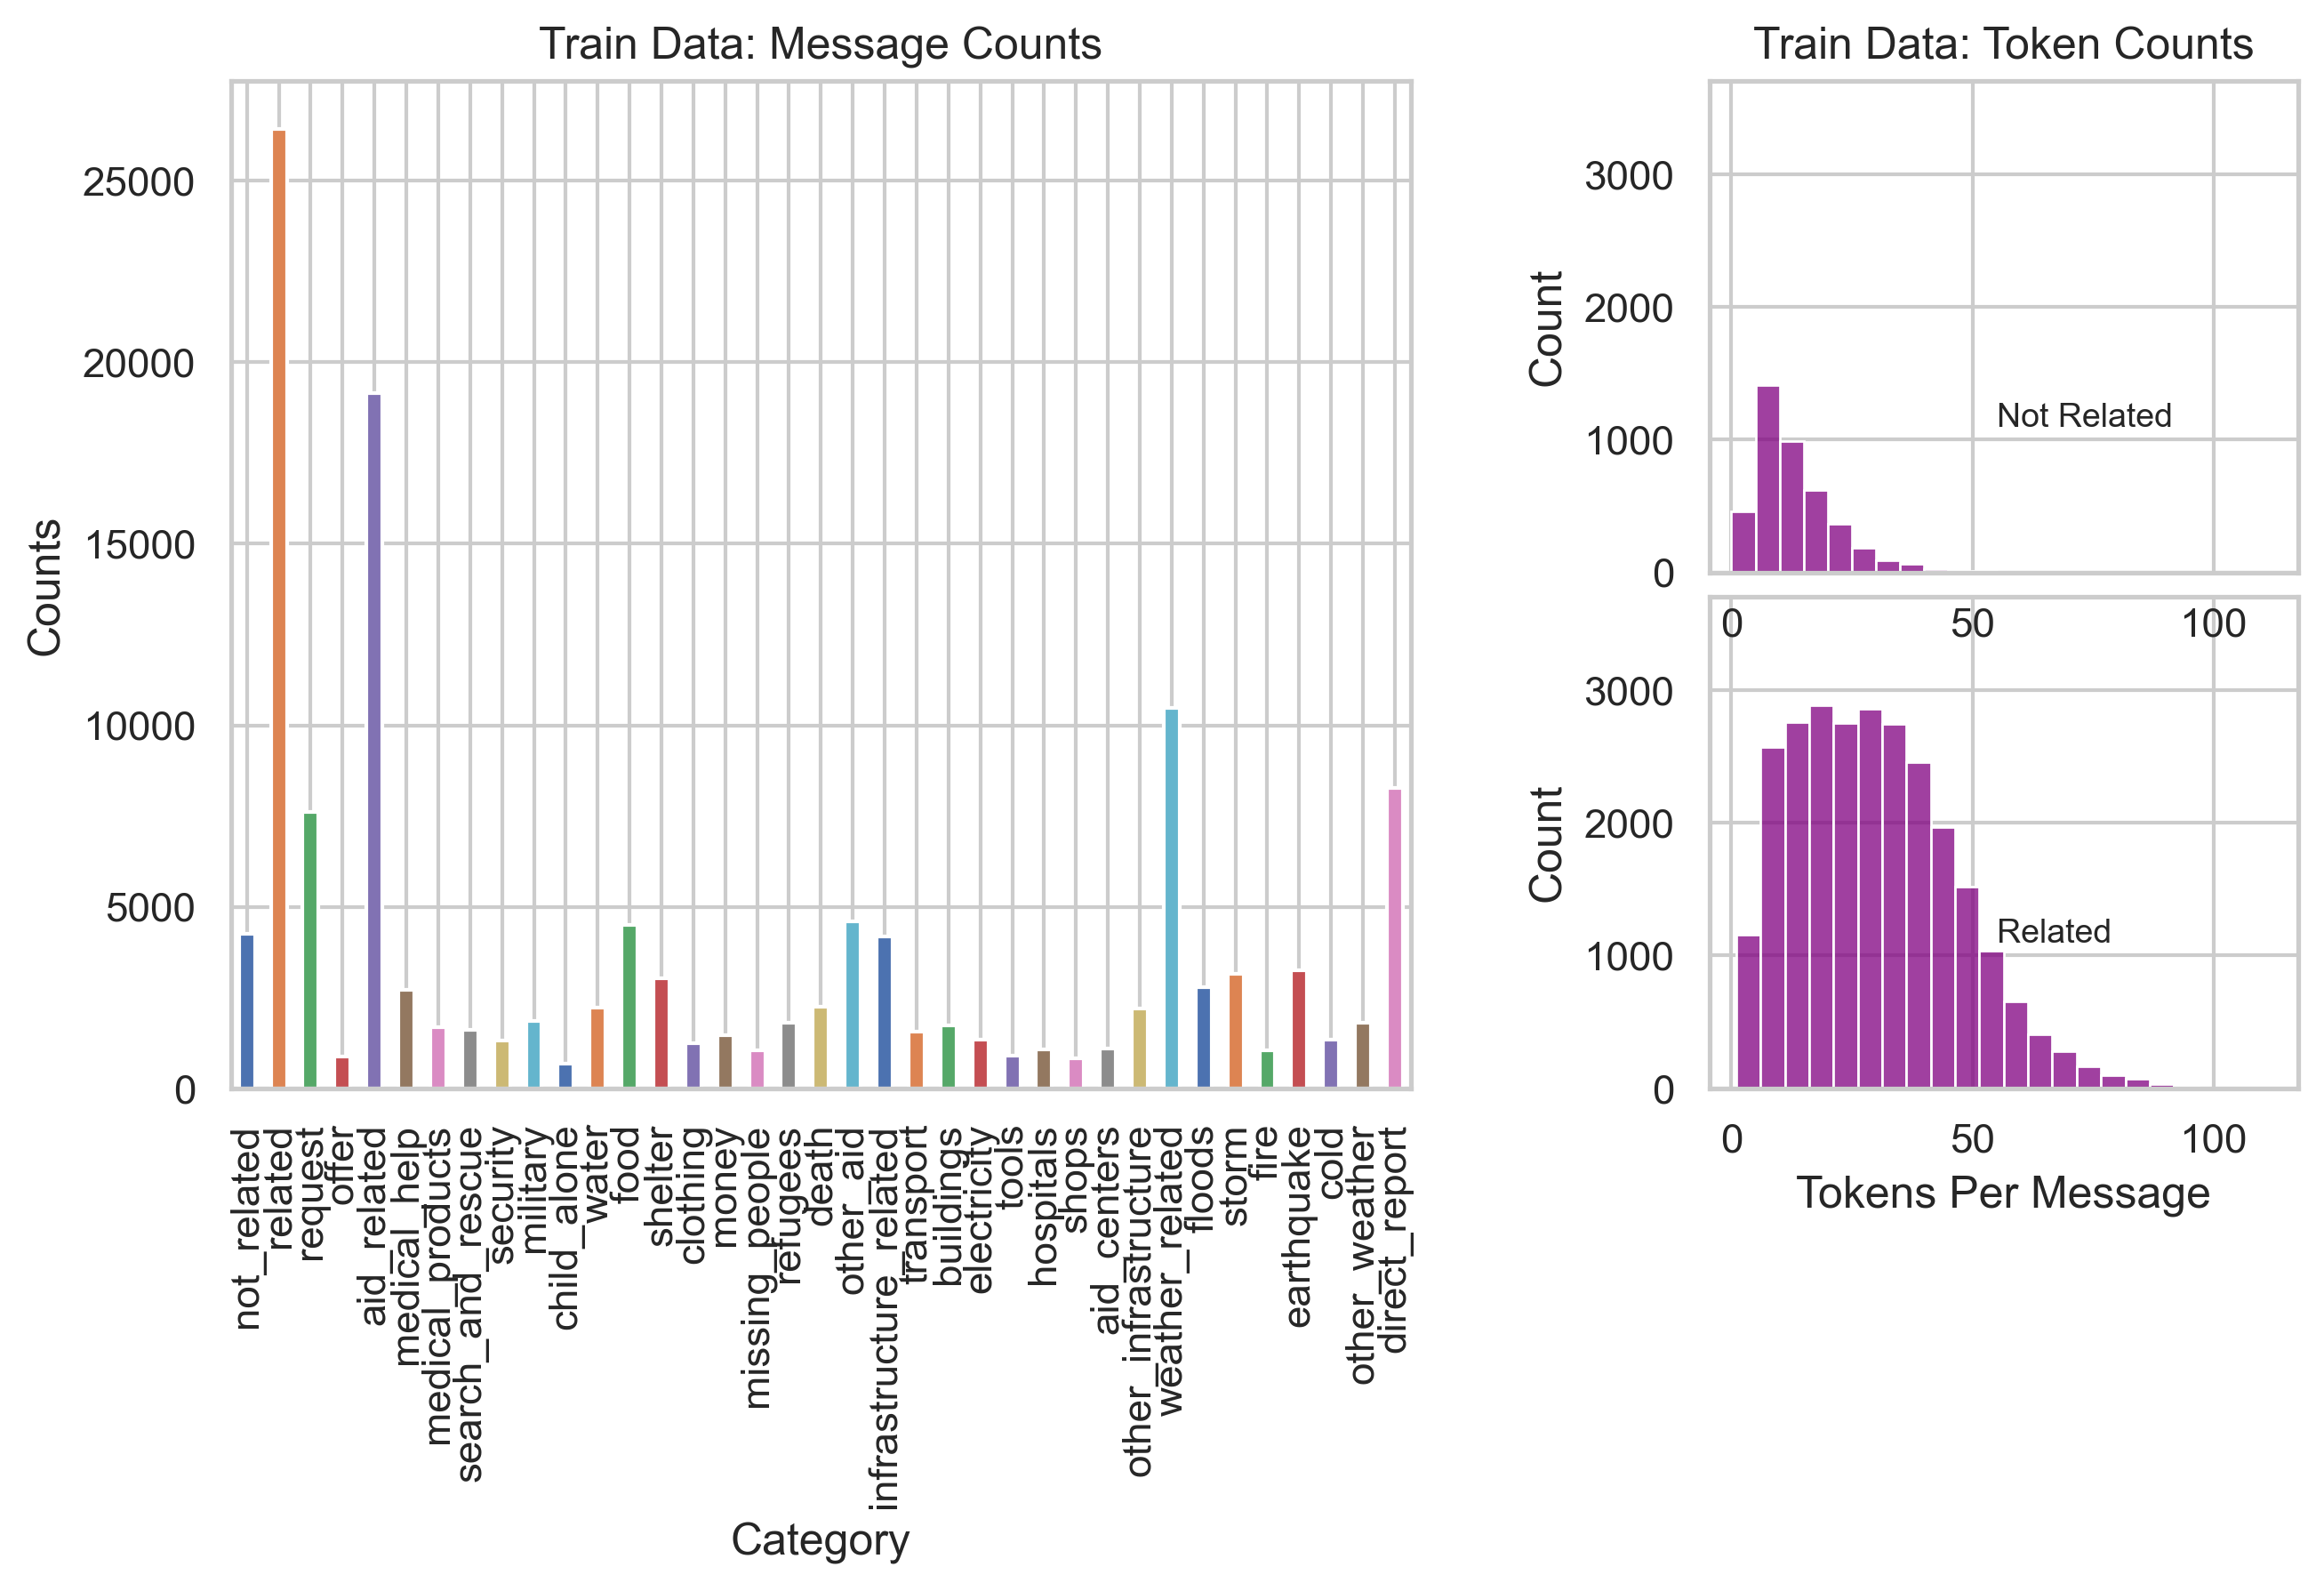

In [153]:
BuildFig(Y_train, 'train_disaster.png')

### 17. Use this notebook to complete `train_classifier.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [140]:
# see test_mlp_r1.ipynb

In [141]:
import buildvisuals

figure saved...


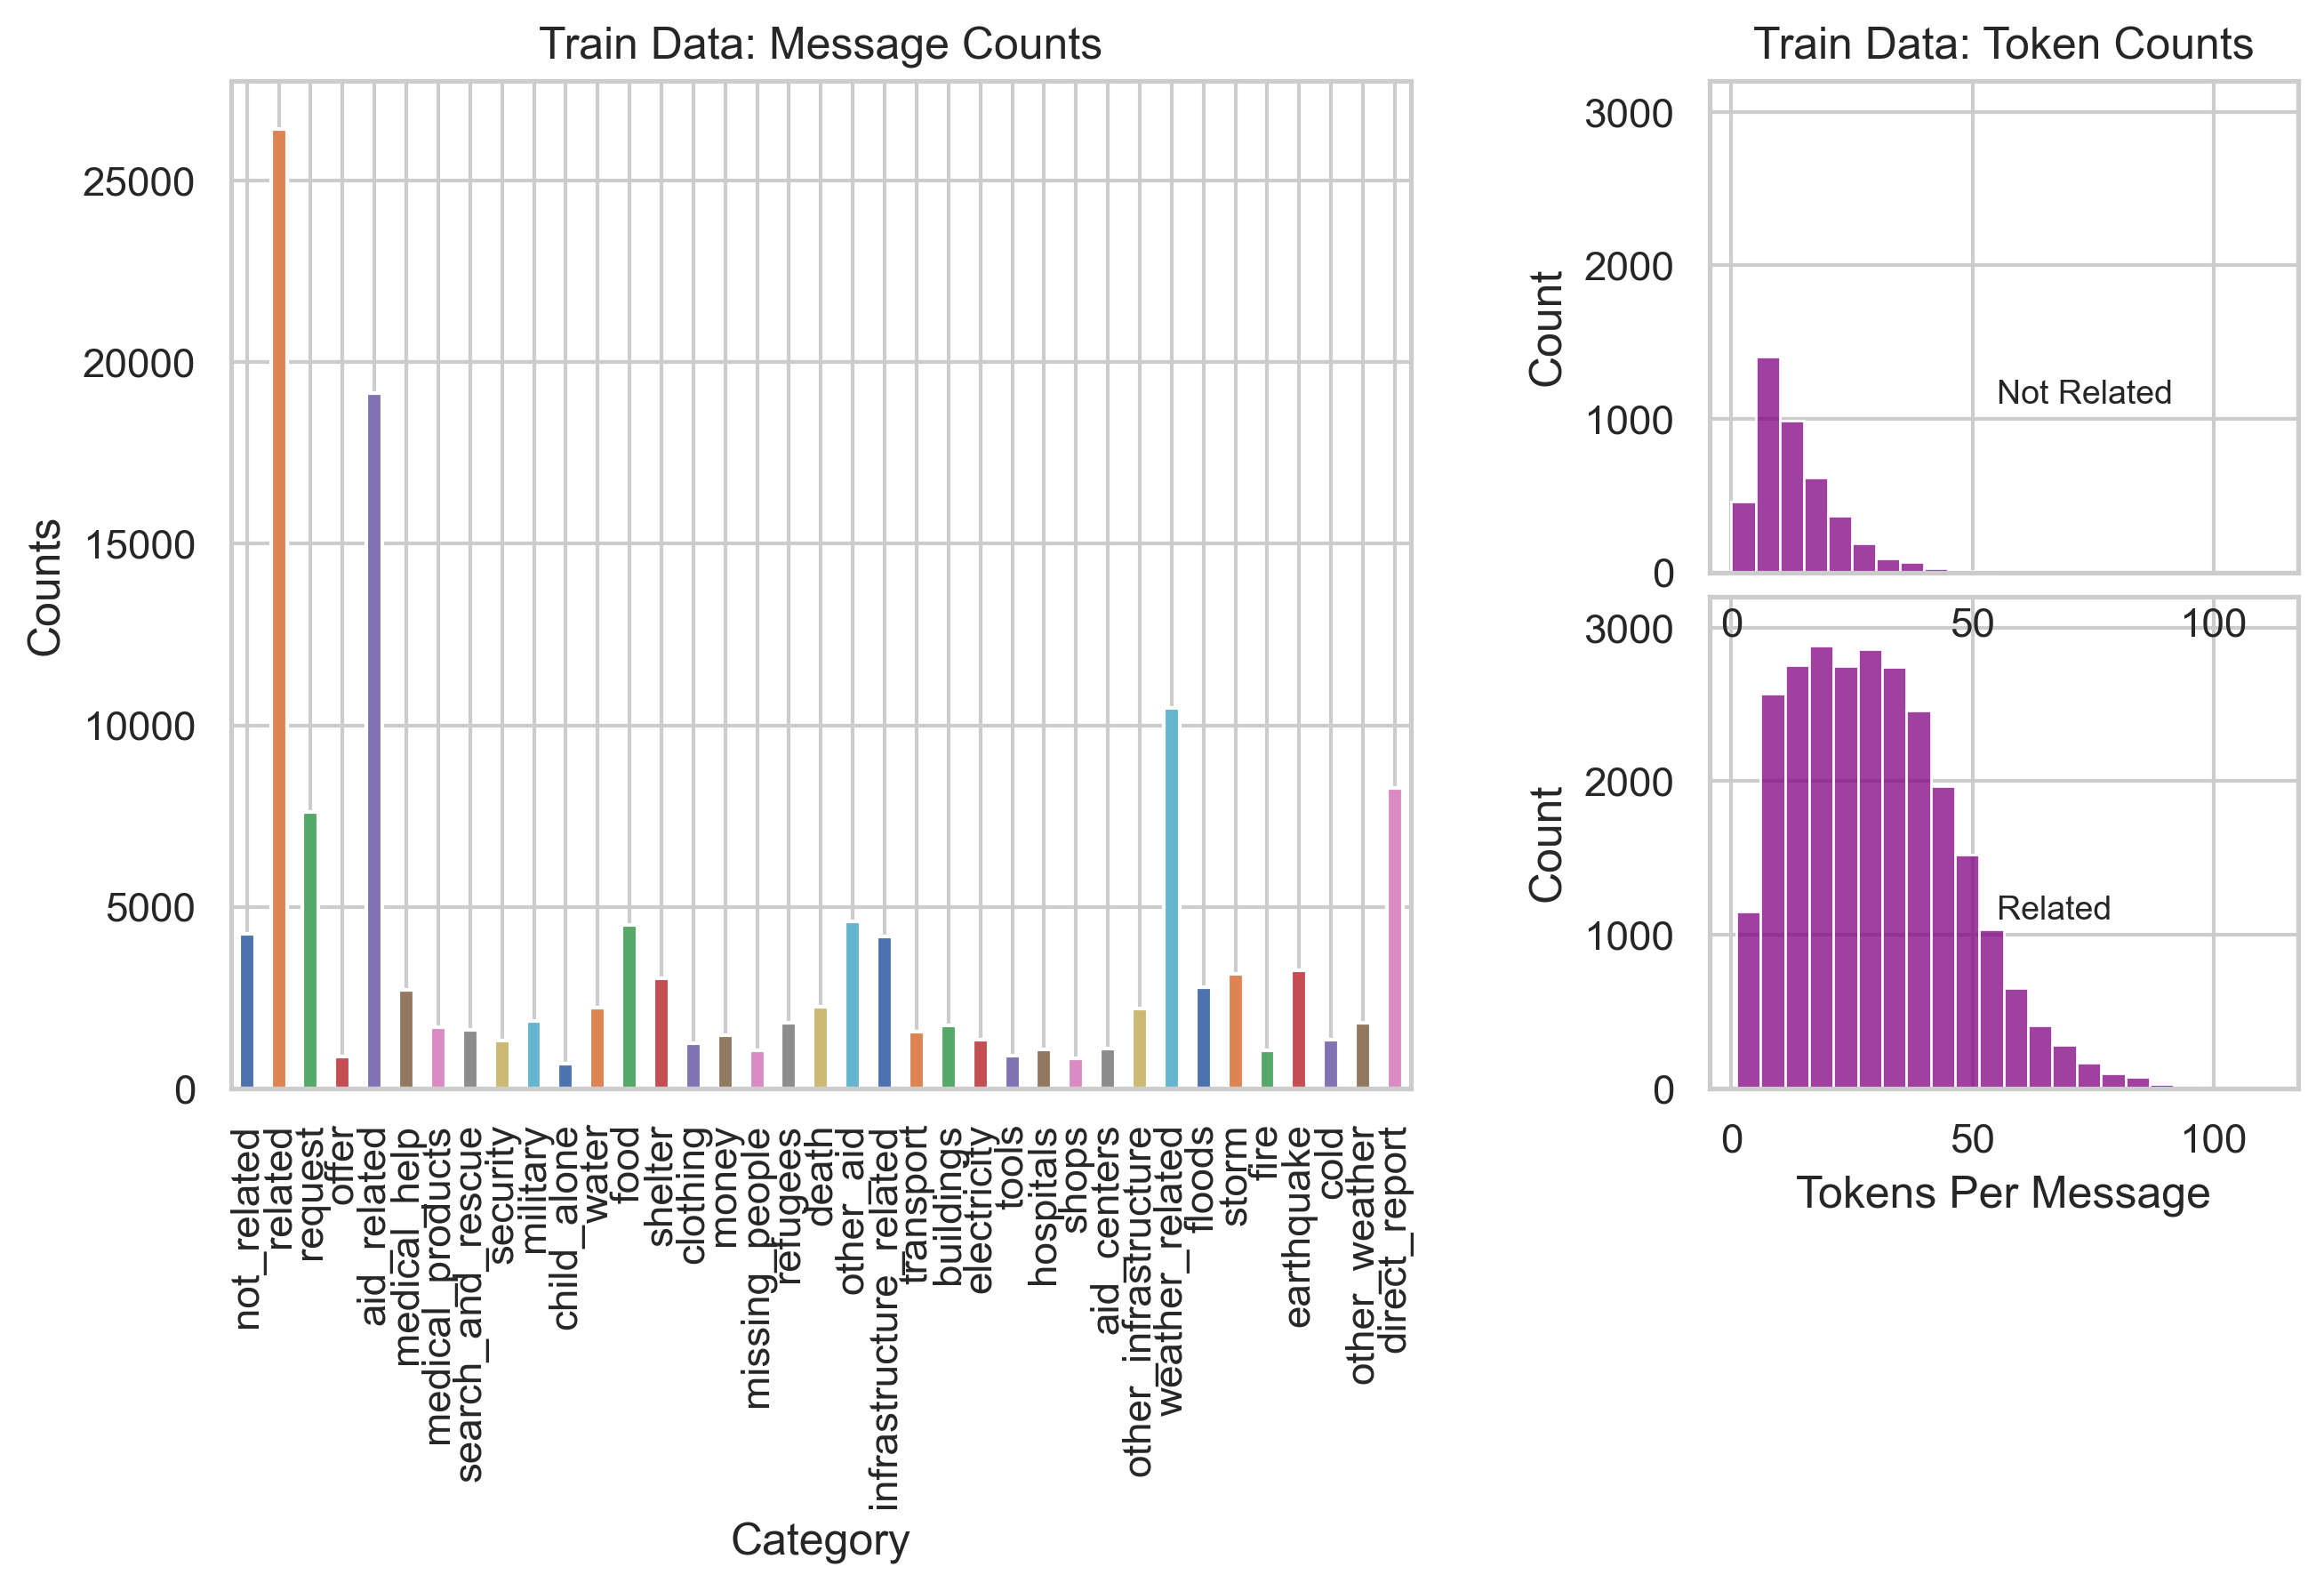

In [143]:
buildvisuals.dft = dft
buildvisuals.BuildFig(Y_train, 'train_disaster_test.png')